In [1]:
%matplotlib inline
from __future__ import division

import numpy as np
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import patsy
import sklearn.linear_model as linear
import random
import re

In [2]:
outbreaks = pd.read_csv("outbreaks.csv")
outbreaks.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19119 entries, 0 to 19118
Data columns (total 12 columns):
Year                 19119 non-null int64
Month                19119 non-null object
State                19119 non-null object
Location             16953 non-null object
Food                 10156 non-null object
Ingredient           1876 non-null object
Species              12500 non-null object
Serotype/Genotype    3907 non-null object
Status               12500 non-null object
Illnesses            19119 non-null int64
Hospitalizations     15494 non-null float64
Fatalities           15518 non-null float64
dtypes: float64(2), int64(2), object(8)
memory usage: 1.8+ MB


*Year*, *Illnesses*, *Hospitalizations*, and *Fatalities* are numerical, and all other columns are categorical. This is expected.

In [3]:
outbreaks.set_index("Year", inplace=True)
outbreaks.describe()

/Users/melissaluo/anaconda/lib/python2.7/site-packages/numpy/lib/function_base.py:3834: RuntimeWarning: Invalid value encountered in percentile
  RuntimeWarning)


,Illnesses,Hospitalizations,Fatalities
count,19119.000000,15494.000000,15518.000000
mean,19.537162,0.947528,0.021717
std,49.452417,5.312772,0.386976
min,2.000000,0.000000,0.000000
25%,3.000000,NaN,NaN
50%,8.000000,NaN,NaN
75%,19.000000,NaN,NaN
max,1939.000000,308.000000,33.000000


There are missing values for *Hospitalizations* and *Fatalities*. I will need to impute missing values. I need to research this some more, but I would impute missing values based on the number of hospitalizations/fatalities for the same pathogen.

In [4]:
outbreaks.describe(include = ['O'])

,Month,State,Location,Food,Ingredient,Species,Serotype/Genotype,Status
count,19119,19119,16953,10156,1876,12500,3907,12500
unique,12,55,161,3127,381,201,239,22
top,May,Florida,Restaurant,Multiple Foods,Fin Fish,Norovirus genogroup I,Unknown,Confirmed
freq,1898,2409,10448,206,190,2744,690,7909


There are 12 months, as expected, but 55 states.

In [71]:
outbreaks.columns

Index([u'Month', u'State', u'Location', u'Food', u'Ingredient', u'Species',
       u'Serotype/Genotype', u'Status', u'Illnesses', u'Hospitalizations',
       u'Fatalities'],
      dtype='object')

In [5]:
np.unique(outbreaks.State.values)

array(['Alabama', 'Alaska', 'Arizona', 'Arkansas', 'California',
       'Colorado', 'Connecticut', 'Delaware', 'Florida', 'Georgia', 'Guam',
       'Hawaii', 'Idaho', 'Illinois', 'Indiana', 'Iowa', 'Kansas',
       'Kentucky', 'Louisiana', 'Maine', 'Maryland', 'Massachusetts',
       'Michigan', 'Minnesota', 'Mississippi', 'Missouri', 'Montana',
       'Multistate', 'Nebraska', 'Nevada', 'New Hampshire', 'New Jersey',
       'New Mexico', 'New York', 'North Carolina', 'North Dakota', 'Ohio',
       'Oklahoma', 'Oregon', 'Pennsylvania', 'Puerto Rico',
       'Republic of Palau', 'Rhode Island', 'South Carolina',
       'South Dakota', 'Tennessee', 'Texas', 'Utah', 'Vermont', 'Virginia',
       'Washington', 'Washington DC', 'West Virginia', 'Wisconsin',
       'Wyoming'], dtype=object)

Washington DC, Puerto Rico, Republic of Palau, Guam, and "Multistate" are our extra 5 "states." 

In [6]:
np.unique(outbreaks.Location.values)

/Users/melissaluo/anaconda/lib/python2.7/site-packages/numpy/lib/arraysetops.py:200: FutureWarning: numpy not_equal will not check object identity in the future. The comparison did not return the same result as suggested by the identity (`is`)) and will change.
  flag = np.concatenate(([True], aux[1:] != aux[:-1]))


array([nan, 'Banquet Facility', 'Banquet Facility; Catering Service',
       'Banquet Facility; Catering Service; Grocery Store',
       'Banquet Facility; Catering Service; Religious Facility',
       'Banquet Facility; Grocery Store',
       'Banquet Facility; Office/Indoor Workplace',
       'Banquet Facility; Religious Facility', 'Banquet Facility; Unknown',
       'Camp', 'Catering Service', 'Catering Service; Camp',
       'Catering Service; Child Daycare',
       'Catering Service; Fair/Festival',
       'Catering Service; Fair/Festival; Grocery Store',
       'Catering Service; Grocery Store',
       'Catering Service; Grocery Store; Office/Indoor Workplace',
       'Catering Service; Hospital',
       'Catering Service; Nursing Home/Assisted Living Facility',
       'Catering Service; Office/Indoor Workplace',
       'Catering Service; Religious Facility',
       'Catering Service; School/College/University',
       'Catering Service; Unknown', 'Child Daycare',
       'Child D

There are listings for *Location* that include multiple places. We'll create a new dictionary that holds the count for the number of times an outbreak occurred at a location, whether by itself or along with other locations as well.

In [4]:
p = re.compile(r"(?<!Food\s)Restaurant")
loc = outbreaks["Location"].values

locations = { "Restaurants": 0,
             "Fast_Food": 0,
             "Private_Home": 0,
             "Banquet_Facilities": 0,
             "Grocery_Store": 0,
             "School": 0,
             "Prison": 0,
             "Nursing_Home": 0,
             "Catering_Services": 0,
             "Religious_Facilities": 0,
             "Camp": 0,
             "Office_Workspace": 0,
             "Fair_Festival": 0,
             "Hospital": 0,
             "Child_Daycare": 0,
             "Farm": 0,
             "Hotel": 0,
             "Unknown": 0 }
for l in loc:
    l = str(l)
    if "nan" in l or "Unknown" in l:
        locations["Unknown"] += 1
    m = p.search(l)
    if m:
        locations["Restaurants"] += 1
    if "Fast" in l:
        locations["Fast_Food"] += 1
    if "Private" in l:
        locations["Private_Home"] += 1
    if "Banquet" in l:
        locations["Banquet_Facilities"] += 1
    if "Grocery" in l:
        locations["Grocery_Store"] += 1
    if "School" in l:
        locations["School"] += 1
    if "Prison" in l:
        locations["Prison"] += 1
    if "Nursing" in l: 
        locations["Nursing_Home"] += 1
    if "Catering" in l:
        locations["Catering_Services"] += 1
    if "Religious" in l:
        locations["Religious_Facilities"] += 1
    if "Camp" in l:
        locations["Camp"] += 1
    if "Office" in l:
        locations["Office_Workspace"] += 1
    if "Fair" in l:
        locations["Fair_Festival"] += 1
    if "Hospital" in l:
        locations["Hospital"] += 1
    if "Daycare" in l:
        locations["Child_Daycare"] += 1
    if "Farm" in l:
        locations["Farm"] += 1
    if "Hotel" in l:
        locations["Hotel"] += 1

total = np.sum(locations.values())
temp = sorted(locations.items(), key=lambda x:x[1], reverse=True)[:10]
locs = []
occ = []
for i, j in temp:
    locs.append(i.replace("_", " "))
    occ.append(j/total) #normalize occurrences of outbreaks 

In [6]:
locations

{'Banquet_Facilities': 476,
 'Camp': 140,
 'Catering_Services': 1466,
 'Child_Daycare': 35,
 'Fair_Festival': 122,
 'Farm': 8,
 'Fast_Food': 434,
 'Grocery_Store': 599,
 'Hospital': 59,
 'Hotel': 1,
 'Nursing_Home': 202,
 'Office_Workspace': 137,
 'Prison': 200,
 'Private_Home': 2314,
 'Religious_Facilities': 175,
 'Restaurants': 11138,
 'School': 415,
 'Unknown': 2538}

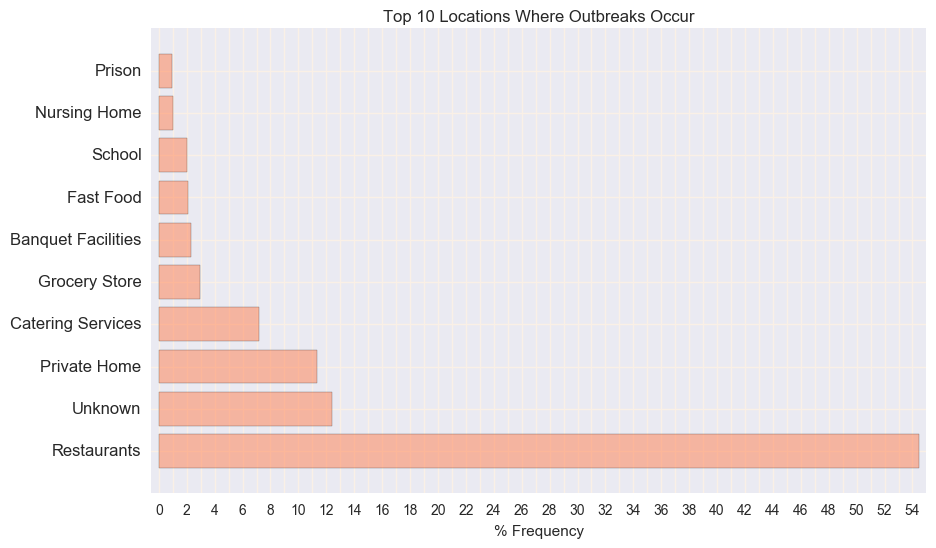

In [5]:
figure = plt.figure(figsize=(10, 6))

axes = figure.add_subplot(1, 1, 1)
axes.barh([i for i in xrange(len(locs))], occ, color="coral", align="center", alpha=0.5)
axes.set_xlabel( "% Frequency")
axes.set_xticks(np.arange(0, 0.56, 0.01))
axes.set_xticklabels(np.arange(0, 56, 1))
for label in axes.get_xticklabels()[1::2]:
    label.set_visible(False)
axes.set_yticks(np.arange(len(locs)))
axes.set_yticklabels(locs, rotation=0, fontsize=12, va="center", ha="right")
axes.set_title("Top 10 Locations Where Outbreaks Occur")
axes.margins(0.01)
axes.yaxis.grid(True)
axes.set_ylim((-1, len(locs)))
axes.grid(color='linen', linestyle='-', linewidth=1)
figure.savefig("locations.pdf", transparent=True, frameon=True, bbox_inches="tight")

The most common place by far of foodborne illness outbreaks are at a restaurant (excluding fast food restaurants, which are their own category), at over 50% of the time. The second most common, at about 12%, is unknown, and following closely behind at around 11% is at a private residence.  

(-1, 10)

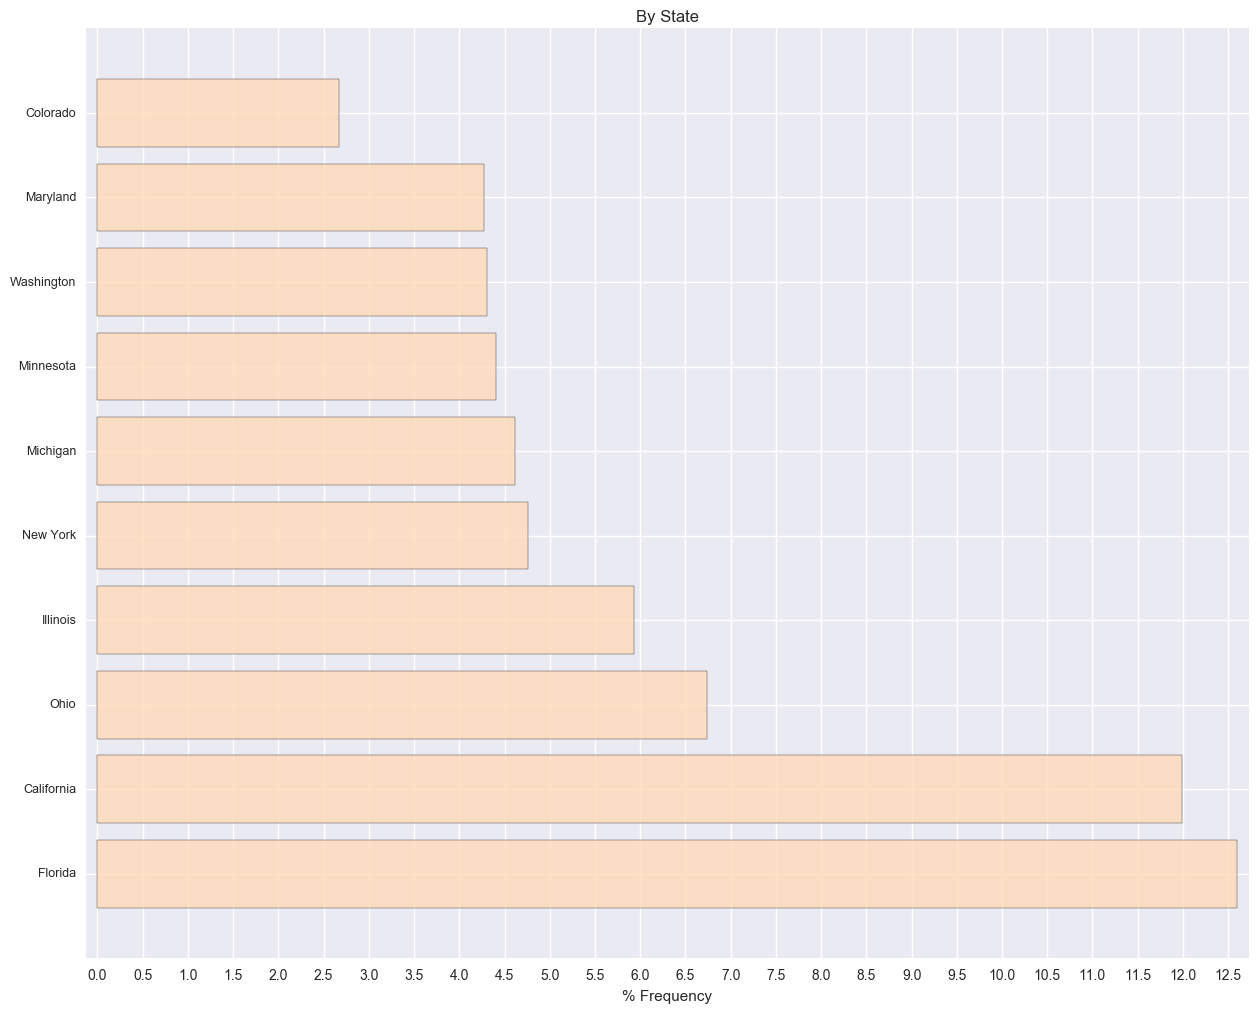

In [10]:
st = np.unique(outbreaks["State"].values) 
n = outbreaks["State"].count() # get count of total outbreaks by state
states = {}
for s in st:
    states[s] = outbreaks[outbreaks["State"] == s]["State"].count() / n

temp = sorted(states.items(), key=lambda x:x[1], reverse=True)[:10]

state_name = []
freq = []
for i, j in temp:
    state_name.append(i)
    freq.append(j)

figure = plt.figure(figsize=(15, 12))

axes = figure.add_subplot(1, 1, 1)
axes.barh([i for i in xrange(len(state_name))], freq, color="peachpuff", align="center", alpha=0.8)
axes.set_xlabel( "% Frequency")
axes.set_xticks(np.arange(0, 0.13, 0.005))
axes.set_xticklabels(np.arange(0, 13, 0.5))
axes.set_yticks(np.arange(len(state_name)))
axes.set_yticklabels(state_name, rotation=0, fontsize=9, va="center", ha="right")
axes.set_title("By State")
axes.margins(0.01, 0.01)
axes.yaxis.grid(True)
axes.set_ylim((-1, len(state_name)))

Florida and California lead the states in most frequent occurrences in outbreaks. This might be slightly misleading, however, since the population of those states are higher than the populations of Delaware and Republic of Palau, the two "cleanest" states/territories. If we normalize by state population (here we will exclude *Republic of Palau*, *Guam*, and *Multistate* -- the former two have low occurrences overall, and multistate is difficult to normalize):

In [12]:
!curl https://en.wikipedia.org/wiki/List_of_U.S._states_by_historical_population -o statepop.html

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  228k    0  228k    0     0   212k      0 --:--:--  0:00:01 --:--:--  223k


In [13]:
!curl http://www.worldometers.info/world-population/puerto-rico-population/ -o puertorico.html

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 36411    0 36411    0     0  51967      0 --:--:-- --:--:-- --:--:--  145k


In [6]:
import statepop

html_doc = open('statepop.html')
table = statepop.get_tables_from_html(html_doc)
popdata = statepop.parse_table(table)
popdata = popdata.set_index("Year")

popdata["Total Population"] = popdata.sum(axis=1)

html_pr = open("puertorico.html").read()
pop_pattern = re.compile(r"(199[89]|200\d|201[0-5]).+(\d{7})")
pr_pop = re.findall(pop_pattern, html_pr)
popdata["Puerto Rico"] = np.nan

for i in pr_pop:
    popdata.set_value(int(i[0]), "Puerto Rico", int(i[1]))
    
popdata.describe()

,Alabama,Alaska,Arizona,Arkansas,California,Colorado,Connecticut,Delaware,Florida,Georgia,...,Utah,Vermont,Virginia,Washington,Washington DC,West Virginia,Wisconsin,Wyoming,Total Population,Puerto Rico
count,1.800000e+01,18.000000,1.800000e+01,1.800000e+01,1.800000e+01,1.800000e+01,1.800000e+01,18.000000,1.800000e+01,1.800000e+01,...,1.800000e+01,18.000000,1.800000e+01,1.800000e+01,18.000000,1.800000e+01,1.800000e+01,18.000000,1.800000e+01,1.800000e+01
mean,4.636119e+06,679736.055556,5.929653e+06,2.809802e+06,3.617441e+07,4.768580e+06,3.502700e+06,856536.166667,1.789832e+07,9.124469e+06,...,2.561058e+06,618543.055556,7.675868e+06,6.425600e+06,590110.222222,1.830296e+06,5.562858e+06,533396.611111,2.988087e+08,3.742757e+06
std,1.735149e+05,43139.532935,6.736651e+05,1.396091e+05,1.893524e+06,4.313326e+05,1.003611e+05,62319.992628,1.595359e+06,8.025523e+05,...,2.864739e+05,10880.054701,4.987399e+05,4.603578e+05,42684.490466,2.016572e+04,1.705535e+05,38022.789397,1.543408e+07,4.190203e+04
min,4.351037e+06,615205.000000,4.667277e+06,2.538202e+06,3.268279e+07,3.968967e+06,3.272563e+06,744066.000000,1.490823e+07,7.636522e+06,...,2.100562e+06,590579.000000,6.789225e+06,5.687832e+06,519000.000000,1.801481e+06,5.222124e+06,479602.000000,2.702480e+08,3.683238e+06
25%,4.485940e+06,643856.250000,5.424782e+06,2.710649e+06,3.496717e+07,4.499988e+06,3.465146e+06,809127.500000,1.676805e+07,8.536890e+06,...,2.333646e+06,616046.000000,7.306899e+06,6.065290e+06,569046.750000,1.811840e+06,5.453672e+06,500876.000000,2.882459e+08,3.703916e+06
50%,4.650910e+06,677801.000000,6.098411e+06,2.835206e+06,3.613576e+07,4.762146e+06,3.522365e+06,865508.500000,1.826742e+07,9.252900e+06,...,2.561626e+06,623186.500000,7.712362e+06,6.416170e+06,574454.000000,1.830982e+06,5.594215e+06,528771.500000,2.998056e+08,3.744101e+06
75%,4.797727e+06,720393.000000,6.457650e+06,2.934397e+06,3.761043e+07,5.101890e+06,3.587739e+06,905804.500000,1.904398e+07,9.788517e+06,...,2.805080e+06,625979.500000,8.088985e+06,6.802062e+06,616622.750000,1.849688e+06,5.703906e+06,566812.750000,3.111280e+08,3.782122e+06
max,4.858979e+06,738432.000000,6.828065e+06,2.978204e+06,3.914482e+07,5.456574e+06,3.599341e+06,945934.000000,2.027127e+07,1.021486e+07,...,2.995919e+06,626855.000000,8.382993e+06,7.170351e+06,672228.000000,1.856313e+06,5.771337e+06,586107.000000,3.214188e+08,3.799366e+06


In [7]:
bystates = outbreaks[["State", "Illnesses"]]
stnames = np.unique(outbreaks["State"].values)
total = {}
for s in stnames:
    total[s] = bystates.loc[bystates["State"] == s, "Illnesses"].sum()
print total

{'Mississippi': 1402, 'Oklahoma': 2163, 'Delaware': 229, 'Minnesota': 13533, 'Illinois': 24700, 'Arkansas': 2383, 'New Mexico': 1466, 'Washington DC': 1481, 'Indiana': 3286, 'Maryland': 9474, 'Louisiana': 4169, 'Idaho': 1829, 'Wyoming': 1720, 'Tennessee': 7475, 'Arizona': 5059, 'Iowa': 4866, 'Multistate': 24573, 'Michigan': 14471, 'Kansas': 5791, 'Utah': 2350, 'Virginia': 7167, 'Oregon': 8960, 'Connecticut': 4151, 'Montana': 1300, 'California': 39992, 'Massachusetts': 6453, 'Puerto Rico': 926, 'South Carolina': 4730, 'New Hampshire': 1933, 'Wisconsin': 11014, 'Vermont': 511, 'Georgia': 10070, 'North Dakota': 2765, 'Pennsylvania': 11374, 'West Virginia': 1091, 'Republic of Palau': 9, 'Florida': 23050, 'Alaska': 1322, 'Kentucky': 712, 'Hawaii': 3558, 'Nebraska': 919, 'Missouri': 4042, 'Ohio': 20451, 'Alabama': 2638, 'Rhode Island': 1171, 'South Dakota': 681, 'Colorado': 10099, 'New Jersey': 4322, 'Guam': 196, 'Washington': 9804, 'North Carolina': 6421, 'New York': 17407, 'Texas': 14187, 

In [8]:
bystates = outbreaks[["State", "Illnesses"]]
bystates = bystates.groupby([bystates.index, "State"]).sum()
bystates.reset_index(level="State", inplace=True)
for yr, sc in zip(bystates.index, bystates.values):
    try:
        if sc[0] == "Multistate":
            stpop = popdata.get_value(yr, "Total Population")
        else:
            stpop = popdata.get_value(yr, sc[0])
        col = sc[0] + "_per_hundred_million"
        popdata.set_value(yr, col, round((sc[1]/stpop)*1000000.0))
    except:
        pass
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
popdata.describe()

,Alabama,Alaska,Arizona,Arkansas,California,Colorado,Connecticut,Delaware,Florida,Georgia,Hawaii,Idaho,Illinois,Indiana,Iowa,Kansas,Kentucky,Louisiana,Maine,Maryland,Massachusetts,Michigan,Minnesota,Mississippi,Missouri,Montana,Nebraska,Nevada,New Hampshire,New Jersey,New Mexico,New York,North Carolina,North Dakota,Ohio,Oklahoma,Oregon,Pennsylvania,Rhode Island,South Carolina,South Dakota,Tennessee,Texas,Utah,Vermont,Virginia,Washington,Washington DC,West Virginia,Wisconsin,Wyoming,Total Population,Puerto Rico,Alabama_per_hundred_million,Alaska_per_hundred_million,Arizona_per_hundred_million,Arkansas_per_hundred_million,California_per_hundred_million,Colorado_per_hundred_million,Connecticut_per_hundred_million,Florida_per_hundred_million,Georgia_per_hundred_million,Hawaii_per_hundred_million,Idaho_per_hundred_million,Illinois_per_hundred_million,Indiana_per_hundred_million,Iowa_per_hundred_million,Kansas_per_hundred_million,Kentucky_per_hundred_million,Louisiana_per_hundred_million,Maine_per_hundred_million,Maryland_per_hundred_million,Massachusetts_per_hundred_million,Michigan_per_hundred_million,Minnesota_per_hundred_million,Mississippi_per_hundred_million,Missouri_per_hundred_million,Montana_per_hundred_million,Multistate_per_hundred_million,Nebraska_per_hundred_million,Nevada_per_hundred_million,New Hampshire_per_hundred_million,New Jersey_per_hundred_million,New Mexico_per_hundred_million,New York_per_hundred_million,North Carolina_per_hundred_million,North Dakota_per_hundred_million,Ohio_per_hundred_million,Oklahoma_per_hundred_million,Oregon_per_hundred_million,Pennsylvania_per_hundred_million,South Carolina_per_hundred_million,South Dakota_per_hundred_million,Tennessee_per_hundred_million,Texas_per_hundred_million,Utah_per_hundred_million,Vermont_per_hundred_million,Virginia_per_hundred_million,Washington_per_hundred_million,Washington DC_per_hundred_million,West Virginia_per_hundred_million,Wisconsin_per_hundred_million,Rhode Island_per_hundred_million,Wyoming_per_hundred_million,Delaware_per_hundred_million,Puerto Rico_per_hundred_million
count,1.800000e+01,18.000000,1.800000e+01,1.800000e+01,1.800000e+01,1.800000e+01,1.800000e+01,18.000000,1.800000e+01,1.800000e+01,1.800000e+01,1.800000e+01,1.800000e+01,1.800000e+01,1.800000e+01,1.800000e+01,1.800000e+01,1.800000e+01,1.800000e+01,1.800000e+01,1.800000e+01,1.800000e+01,1.800000e+01,1.800000e+01,1.800000e+01,1.800000e+01,1.800000e+01,1.800000e+01,1.800000e+01,1.800000e+01,1.800000e+01,1.800000e+01,1.800000e+01,18.000000,1.800000e+01,1.800000e+01,1.800000e+01,1.800000e+01,1.800000e+01,1.800000e+01,18.000000,1.800000e+01,1.800000e+01,1.800000e+01,18.000000,1.800000e+01,1.800000e+01,18.000000,1.800000e+01,1.800000e+01,18.000000,1.800000e+01,1.800000e+01,18.000000,18.000000,18.000000,18.000000,18.000000,18.000000,18.000000,18.000000,18.000000,18.000000,18.000000,18.000000,15.000000,18.000000,18.000000,14.000000,18.000000,16.000000,18.000000,18.000000,18.000000,18.000000,15.000000,18.000000,11.000000,18.000000,15.000000,14.000000,18.000000,18.000000,17.000000,18.000000,18.000000,16.000000,18.000000,18.000000,18.000000,18.000000,18.000000,16.00000,18.000000,18.000000,18.000000,16.000000,18.000000,18.000000,9.000000,15.000000,18.000000,13.000000,16.000000,9.000000,9.000000
mean,4.636119e+06,679736.055556,5.929653e+06,2.809802e+06,3.617441e+07,4.768580e+06,3.502700e+06,856536.166667,1.789832e+07,9.124469e+06,1.309553e+06,1.463366e+06,1.263830e+07,6.325696e+06,2.996210e+06,2.784367e+06,4.220695e+06,4.506288e+06,1.310059e+06,5.622490e+06,6.480153e+06,9.946911e+06,5.166950e+06,2.910955e+06,5.828667e+06,9.565022e+05,1.782094e+06,2.446220e+06,1.289378e+06,8.652165e+06,1.954469e+06,1.919901e+07,8.949155e+06,668148.722222,1.146916e+07,3.628186e+06,3.680037e+06,1.250533e+07,1.050966e+06,4.389280e+06,792235.777778,6.088409e+06,2.361921e+07,2.561058e+06,618543.055556,7.675868e+06,6.425600e+06,590110.222222,1.830296e+06,5.562858e+06,533396.611111,2.988087e+08,3.742757e+06,31.777778,110.

In [79]:
popdata.mean(axis=0)[53:]

Alabama_per_hundred_million            31.777778
Alaska_per_hundred_million            110.055556
Arizona_per_hundred_million            46.333333
Arkansas_per_hundred_million           46.944444
California_per_hundred_million         62.722222
Colorado_per_hundred_million          118.722222
Connecticut_per_hundred_million        65.888889
Florida_per_hundred_million            74.888889
Georgia_per_hundred_million            63.666667
Hawaii_per_hundred_million            154.888889
Idaho_per_hundred_million              69.833333
Illinois_per_hundred_million          109.166667
Indiana_per_hundred_million            35.800000
Iowa_per_hundred_million               90.944444
Kansas_per_hundred_million            115.666667
Kentucky_per_hundred_million           11.857143
Louisiana_per_hundred_million          51.611111
Maine_per_hundred_million             229.875000
Maryland_per_hundred_million           96.111111
Massachusetts_per_hundred_million      55.722222
Michigan_per_hundred

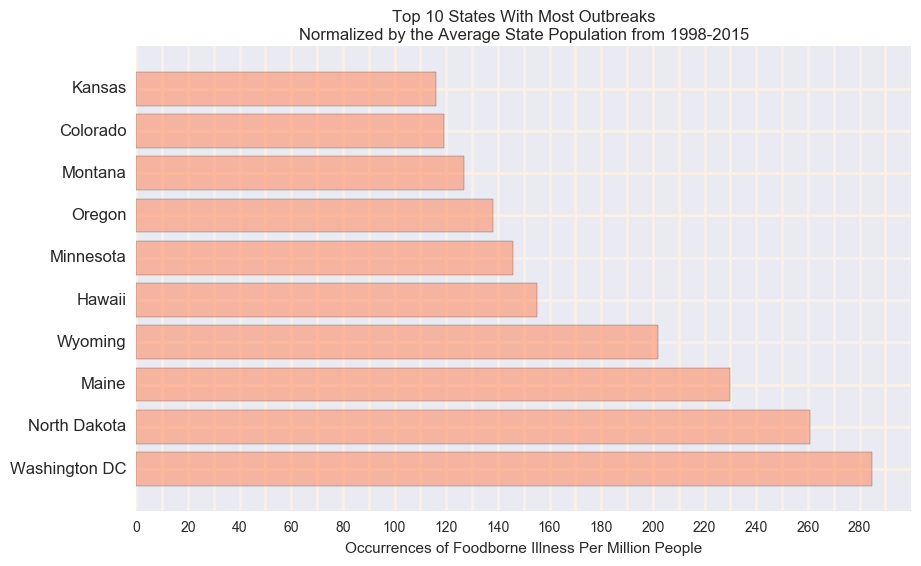

In [9]:
normalized = popdata.mean(axis=0)[53:].to_dict()

temp = sorted(normalized.items(), key=lambda x:x[1], reverse=True)[:10]

state_name = []
freq = []
for i, j in temp:
    stlist = i.split("_")
    state_name.append(stlist[0])
    freq.append(round(j))

figure = plt.figure(figsize=(10, 6))
width = 1/1.5
axes = figure.add_subplot(1, 1, 1)
axes.barh([i for i in xrange(len(state_name))], freq, color="coral", align="center", alpha=0.5)
axes.set_xlabel("Occurrences of Foodborne Illness Per Million People")
axes.set_title( "Top 10 States With Most Outbreaks\nNormalized by the Average State Population from 1998-2015", fontsize=12)
axes.set_xticks(np.arange(0, 300, 10))
axes.set_xticklabels(np.arange(0, 300, 10))
for label in axes.get_xticklabels()[1::2]:
    label.set_visible(False)
axes.set_xlim(0, 300)
axes.set_yticks(np.arange(len(state_name)))
axes.set_yticklabels(state_name, rotation=0, fontsize=12, va="center", ha="right")
axes.yaxis.grid(True)
axes.set_ylim((-1, len(state_name)))

axes.grid(color='linen', linestyle='-', linewidth=2)
figure.savefig("states.pdf", transparent=True, frameon=True, bbox_inches="tight")

In [54]:
st = np.unique(outbreaks["State"].values).tolist()
st.remove("Republic of Palau")
st.remove("Guam")
n = outbreaks["State"].count() # get count of total outbreaks by state
states = {}
for s in st:
    states[s] = outbreaks[outbreaks["State"] == s]["State"].count() / n

temp = sorted(states.items(), key=lambda x:x[1], reverse=True)

stpop = popdata.mean()[:53]


ValueError: cannot convert float NaN to integer

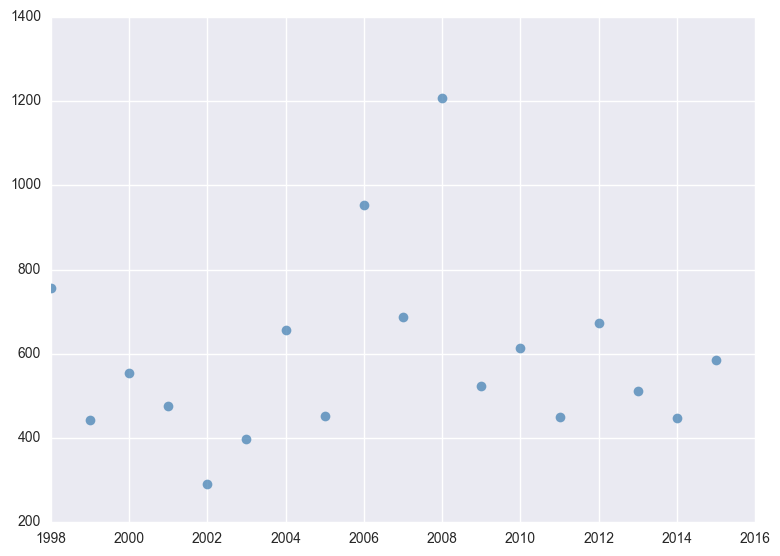

In [7]:
from itertools import cycle

years = popdata.index.values
st_name = popdata.columns[:52]
st_freq = popdata.columns[52:]

# divide states/territories into 8 regions for somewhat easier visualization

new_england = ["Connecticut", "Maine", "Massachusetts", "New Hampshire", "Rhode Island", "Vermont"]
midatlantic = ["New Jersey", "New York", "Pennsylvania", "Delaware", "Washington DC", "Maryland"]
south_atlantic = ["Florida", "Georgia", "North Carolina", "South Carolina",  "Virginia", "West Virginia", "Puerto Rico"]
great_lakes = ["Illinois", "Indiana", "Michigan", "Ohio", "Wisconsin"]
plains = ["Iowa", "Kansas", "Minnesota", "Missouri", "Nebraska", "North Dakota", "South Dakota"]
pacific = ["Alaska", "California", "Hawaii", "Oregon", "Washington"]
south = ["Alabama", "Arkansas", "Kentucky", "Louisiana", "Mississippi", "Oklahoma", "Tennessee", "Texas"]
mountain = ["Arizona", "Colorado", "Idaho", "Montana", "Nevada", "New Mexico", "Utah", "Wyoming"]

colors = cycle(["steelblue", "firebrick", "purple", "coral", "navy", "crimson", "violet", "goldenrod"])

markers = cycle(["o", "^", "s", "D", "*", "v"])

figure = plt.figure(figsize=(20, 30))

axes = figure.add_subplot(4, 2, 1)

for i, k in enumerate(st_freq):
    if st_name[i] in new_england:
        s = map(int, popdata[k].tolist())
        axes.plot(years, s, next(markers), color=colors.next(), alpha=0.75, label=st_name[i])
axes.set_xticks(years)
axes.set_xticklabels(years)
axes.set_yticks([i for i in range(0,50,5)])
axes.legend()
axes.set_title("Northeast New England Region")
axes.set_xlabel("Year")
axes.set_ylabel("Cases Per Million People")
axes.margins(0.01, 0.01)
axes.yaxis.grid(True)
axes.set_ylim((-1, 50))
axes.mouseover
axes.can_zoom()

axes = figure.add_subplot(4, 2, 2)

for i, k in enumerate(st_freq):
    if st_name[i] in midatlantic:
        s = map(int, popdata[k].tolist())
        axes.plot(years, s, next(markers), color=colors.next(), alpha=0.75, label=st_name[i])
axes.set_xticks(years)
axes.set_xticklabels(years)
axes.set_yticks([i for i in range(0,50,5)])
axes.legend()
axes.set_title("Northeast Mid-Atlantic Region")
axes.set_xlabel("Year")
axes.set_ylabel("Cases Per Million People")
axes.margins(0.01, 0.01)
axes.yaxis.grid(True)
axes.set_ylim((-1, 50))
axes.mouseover
axes.can_zoom()

axes = figure.add_subplot(4, 2, 3)

for i, k in enumerate(st_freq):
    if st_name[i] in great_lakes:
        s = map(int, popdata[k].tolist())
        axes.plot(years, s, next(markers), color=colors.next(), alpha=0.75, label=st_name[i])
axes.set_xticks(years)
axes.set_xticklabels(years)
axes.set_yticks([i for i in range(0,50,5)])
axes.legend()
axes.set_title("Midwest Great Lakes Region")
axes.set_xlabel("Year")
axes.set_ylabel("Cases Per Million People")
axes.margins(0.01, 0.01)
axes.yaxis.grid(True)
axes.set_ylim((-1, 50))
axes.mouseover
axes.can_zoom()

axes = figure.add_subplot(4, 2, 4)

for i, k in enumerate(st_freq):
    if st_name[i] in plains:
        s = map(int, popdata[k].tolist())
        axes.plot(years, s, next(markers), color=colors.next(), alpha=0.75, label=st_name[i])
        
axes.set_xticks(years)
axes.set_xticklabels(years)
axes.set_yticks([i for i in range(0,50,5)])
axes.legend()
axes.set_title("Midwest Plains Region")
axes.set_xlabel("Year")
axes.set_ylabel("Cases Per Million People")
axes.margins(0.01, 0.01)
axes.yaxis.grid(True)
axes.set_ylim((-1, 50))
axes.mouseover
axes.can_zoom()

axes = figure.add_subplot(4, 2, 5)

for i, k in enumerate(st_freq):
    if st_name[i] in south_atlantic:
        s = map(int, popdata[k].tolist())
        axes.plot(years, s, next(markers), color=colors.next(), alpha=0.75, label=st_name[i])
        continue
        
axes.set_xticks(years)
axes.set_xticklabels(years)
axes.set_yticks([i for i in range(0,50,5)])
axes.legend()
axes.set_title("South Atlantic Region")
axes.set_xlabel("Year")
axes.set_ylabel("Cases Per Million People")
axes.margins(0.01, 0.01)
axes.yaxis.grid(True)
axes.set_ylim((-1, 50))
axes.mouseover
axes.can_zoom()

axes = figure.add_subplot(4, 2, 6)

for i, k in enumerate(st_freq):
    if st_name[i] in south:
        s = map(int, popdata[k].tolist())
        axes.plot(years, s, next(markers), color=colors.next(), alpha=0.75, label=st_name[i])
        
axes.set_xticks(years)
axes.set_xticklabels(years)
axes.set_yticks([i for i in range(0,50,5)])
axes.legend()
axes.set_title("South Central Region")
axes.set_xlabel("Year")
axes.set_ylabel("Cases Per Million People")
axes.margins(0.01, 0.01)
axes.yaxis.grid(True)
axes.set_ylim((-1, 50))
axes.mouseover
axes.can_zoom()

axes = figure.add_subplot(4, 2, 7)

for i, k in enumerate(st_freq):
    if st_name[i] in mountain:
        s = map(int, popdata[k].tolist())
        axes.plot(years, s, next(markers), color=colors.next(), alpha=0.75, label=st_name[i])
        
axes.set_xticks(years)
axes.set_xticklabels(years)
axes.set_yticks([i for i in range(0,50,5)])
axes.legend()
axes.set_title("Mountain Region")
axes.set_xlabel("Year")
axes.set_ylabel("Cases Per Million People")
axes.margins(0.01, 0.01)
axes.yaxis.grid(True)
axes.set_ylim((-1, 50))
axes.mouseover
axes.can_zoom()

axes = figure.add_subplot(4, 2, 8)

for i, k in enumerate(st_freq):
    if st_name[i] in pacific:
        s = map(int, popdata[k].tolist())
        axes.plot(years, s, next(markers), color=colors.next(), alpha=0.75, label=st_name[i])
        
axes.set_xticks(years)
axes.set_xticklabels(years)
axes.set_yticks([i for i in range(0,50,5)])
axes.legend()
axes.set_title("Pacific Region")
axes.set_xlabel("Year")
axes.set_ylabel("Cases Per Million People")
axes.margins(0.01, 0.01)
axes.yaxis.grid(True)
axes.set_ylim((-1, 50))
axes.mouseover
axes.can_zoom()

plt.show()

The graphs individually are still overcrowded, but overall we can see that if we look at cases per million of people, Hawaii from 1998-2005 had the most outbreaks, followed by Maryland and Florida. We do see an overall trend in less outbreaks as we move to the 2010s. There is an interesting uptick in outbreaks in Maine from 2005 to 2008, and similarly in Kansas.

If we simply look at outbreaks per year:

In [109]:
cols = list(popdata)
cols[51], cols[52] = cols[52], cols[51]
statesonly = popdata.iloc[:, :51]
byyear = outbreaks[["Illnesses"]]
byyear = byyear.groupby(byyear.index).sum()
byyear

,Illnesses
Year,
1998,27156
1999,24899
2000,26033
2001,25192
2002,24939
2003,23079
2004,29034
2005,19761
2006,28656


In [10]:
byyear = outbreaks[["Illnesses"]]
byyear = byyear.groupby(byyear.index).sum()
year_counts = [y for x in byyear.values.tolist() for y in x]
statesonly = popdata.iloc[:, :51]
total_pop = np.array(statesonly.sum(axis=1))
years = [i for i in xrange(1998, 2016)]
norm = np.round(year_counts/total_pop * 1000000.0) #normalize frequency of outbreaks by total population
print norm
print year_counts

[ 100.   91.   92.   88.   87.   80.   99.   67.   96.   70.   76.   45.
   51.   46.   48.   42.   42.   47.]
[27156, 24899, 26033, 25192, 24939, 23079, 29034, 19761, 28656, 20970, 23089, 13813, 15893, 14278, 14995, 13431, 13295, 15018]


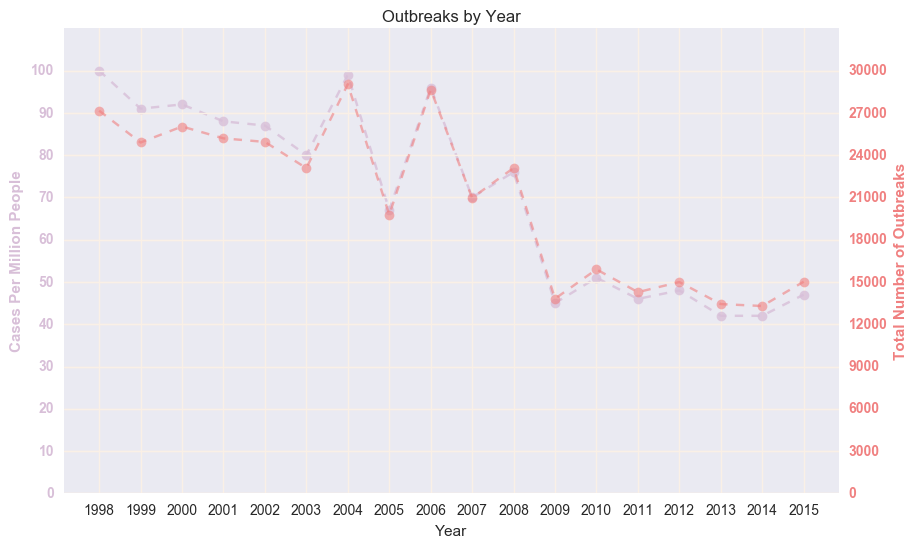

In [188]:

figure = plt.figure(figsize=(10, 6))
axes = figure.add_subplot(1, 1, 1)
axes.plot(years, norm, "o--", color="thistle", alpha=0.8)
axes.set_ylim(0, 110)
axes.set_yticks([i for i in range(0, 110, 10)])
axes.set_xticks([i for i in xrange(1998,2016)])
axes.margins(0.05)
axes.set_ylabel("Cases Per Million People", color="thistle", fontweight="bold")
axes.set_yticklabels([i for i in range(0, 110, 10)], fontweight="bold")
axes.set_xlabel("Year")
axes.set_title("Outbreaks by Year")
for tl in axes.get_yticklabels():
    tl.set_color("thistle")
    
ax2 = axes.twinx()
ax2.plot(years, year_counts,"o--", color="lightcoral", alpha=0.6)
ax2.set_ylabel("Total Number of Outbreaks", color="lightcoral", fontweight="bold")
ax2.set_ylim(0, 33000)
ax2.set_yticks([i for i in xrange(0,33000, 3000)])
ax2.set_yticklabels([i for i in xrange(0,33000, 3000)], fontweight="bold")
ax2.margins(0.05)
for tl in ax2.get_yticklabels():
    tl.set_color("lightcoral")

axes.grid(color='linen', linestyle='-', linewidth=1)
ax2.grid(color='linen', linestyle='-', linewidth=1)
figure.savefig("yearly.pdf", transparent=True, frameon=True, bbox_inches="tight")

If we only look at the total number of outbreaks by year, it would seem to be increasing from 1998 to 2000, and from 2011 to 2015. However, in those time frames, if we look at cases per million, normalized by the total U.S. population, it's about the same (1 in every 200,000 people fell ill, and 1 in every 333,333 people fell ill, respectively). Both graphs show that 2009 was the "cleanest" year (which is also around the peak of the recession - perhaps people ate out less?), and since 2010 we've not really improved from 1 in every 333,333 people getting sick.

Let's see if there's a particular month, or months, where foodborne illnesses tend to peak:

In [20]:
bymonth = outbreaks[["Month", "Illnesses"]]
bymonth = bymonth.groupby([bymonth.index, "Month"]).sum()
bymonth.reset_index(level="Month", inplace=True)


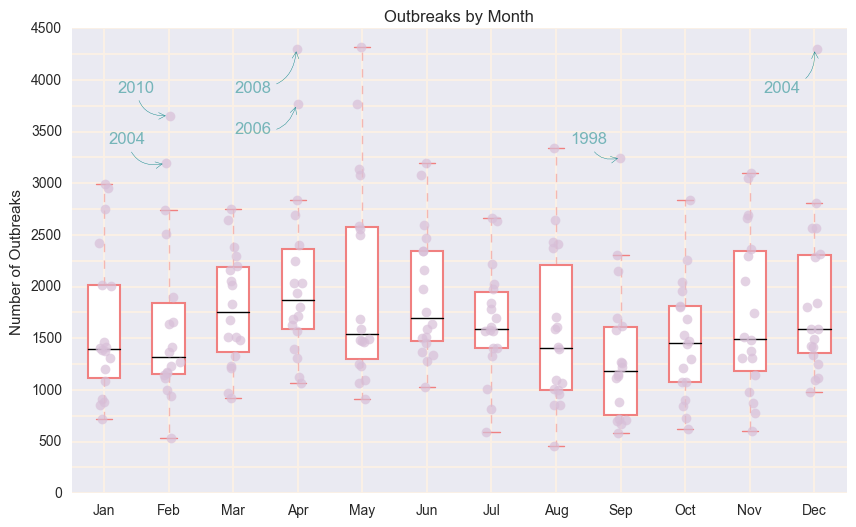

In [179]:
months = {1: "January",
         2: "February",
         3: "March",
         4: "April",
         5: "May",
         6: "June",
         7: "July",
         8: "August",
         9: "September",
         10: "October",
         11: "November",
         12: "December"}

yearly = {1998: {},
         1999: {},
         2000: {},
         2001: {},
         2002: {},
         2003: {},
         2004: {},
         2005: {},
         2006: {},
         2007: {},
         2008: {},
         2009: {},
         2010: {},
         2011: {},
         2012: {},
         2013: {},
         2014: {},
         2015: {}}

for yr, mc in zip(bymonth.index, bymonth.values):
    yearly[yr][mc[0]] = mc[1]

boxplots = {}
points = []

toyear = {0: "1998", 1: "1999", 2: "2000", 3: "2001", 4: "2002", 5: "2003", 6: "2004", 7: "2005", 8: "2006",
         9: "2007", 10: "2008", 11: "2009", 12: "2010", 13: "2011", 14: "2012", 15: "2013", 16: "2014", 17: "2015"}
for mo in sorted(months.items(), key=lambda x: x[0]):
    boxplots[mo[1]] = []
    for yr in sorted(yearly.items(), key=lambda x: x[0]):
        boxplots[mo[1]].append(yr[1][mo[1]])
        
for mo in sorted(months.items(), key=lambda x: x[0]):
    points.append(boxplots[mo[1]])

def restyle_boxplot( patch):
    ## change color and linewidth of the whiskers
    for whisker in patch['whiskers']:
        whisker.set(color='lightcoral', linewidth=1, alpha=0.5)

    ## change color and linewidth of the caps
    for cap in patch['caps']:
        cap.set(color='lightcoral', linewidth=1)

    ## change color and linewidth of the medians
    for median in patch['medians']:
        median.set(color='black', linewidth=1)

    for box in patch['boxes']:
        box.set(edgecolor='lightcoral', linewidth=1.5)
        
figure = plt.figure(figsize=(10, 6))
axes = figure.add_subplot(1, 1, 1)
flierprops = {"markerfacecolor": "teal", "marker":"s"}
months = [mo[1] for mo in sorted(months.items(), key=lambda x:x[0])]
patch = axes.boxplot(points, patch_artist=True)
restyle_boxplot( patch)

np.random.seed([209589013])
for i in range(len(points)):
    data = points[i]
    x = np.random.normal(i + 1, 0.05, size=len(data))
    axes.plot(x, data, 'o', alpha=0.7, color="thistle")

axes.set_xticklabels([m[:3] for m in months])
axes.set_ylim(0, 4500)
axes.set_yticks(range(0, 4510, 250))
for label in axes.get_yticklabels()[1::2]:
    label.set_visible(False)
axes.set_ylabel("Number of Outbreaks")
axes.set_title("Outbreaks by Month")

axes.annotate("2004", xy=(1.95, 3193), xytext=(1.35,3500), color="teal", ha='center', va='top', alpha=0.5,
              arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0.5', color='teal'))
axes.annotate("2010", xy=(2, 3654), xytext=(1.5,4000), color="teal", ha='center', va='top', alpha=0.5,
              arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0.5', color='teal'))
axes.annotate("2006", xy=(3.98, 3765), xytext=(3.3,3600), color="teal", ha='center', va='top', alpha=0.5,
              arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0.5', color='teal'))
axes.annotate("2008", xy=(3.98, 4303), xytext=(3.3,4000), color="teal", ha='center', va='top', alpha=0.5,
              arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0.5', color='teal'))
axes.annotate("1998", xy=(9, 3248), xytext=(8.5,3500), color="teal", ha='center', va='top', alpha=0.5,
              arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0.5', color='teal'))
axes.annotate("2004", xy=(12, 4303), xytext=(11.5,4000), color="teal", ha='center', va='top', alpha=0.5,
              arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0.5', color='teal'))

axes.grid(color='linen', linestyle='-', linewidth=1.5)
figure.savefig("monthly.pdf", transparent=True, frameon=True, bbox_inches="tight")

# http://stackoverflow.com/questions/9074996/matplotlib-how-to-annotate-point-on-a-scatter-automatically-placed-arrow
# http://stackoverflow.com/questions/22272081/label-python-data-points-on-plot

In [133]:

print boxplots["April"]


[2400, 2244, 1688, 1938, 2836, 1711, 2036, 2694, 3765, 1572, 4303, 1069, 2032, 1807, 1122, 1401, 1627, 1312]


Difficult to decipher, but overall it seems December tends to have the most outbreaks, and October the least.

Let's look at the types of pathogens, and how many illnesses they cause.

In [63]:
tox = outbreaks["Species"].values
tox = ["Unknown" if x is np.nan else x for x in tox]

pathogens = {"Adenovirus": 0,
            "shellfish poison": 0,
            "Anisakis": 0,
            "Astrovirus": 0,
            "Bacillus": 0,
            "Brucella": 0,
            "Bacterium": 0,
            "Campylobacter": 0,
            "Chemicals_toxin_metals": 0,
            "Ciguatoxin": 0,
            "Clostridium": 0,
            "Cryptosporidium": 0,
            "Cyclospora": 0,
            "Enterobacter": 0,
            "Enterococcus faecalis": 0,
            "Escherichia coli": 0,
            "Giardia": 0,
            "Hepatitis A": 0,
            "Listeria": 0,
            "Mycotoxins": 0,
            "Norovirus": 0,
            "Parasite": 0,
            "Puffer fish tetrodoxin": 0,
            "Rotavirus": 0,
            "Salmonella": 0,
            "Sapovirus": 0,
            "Scombroid toxin": 0,
            "Shigella": 0,
            "Staphylococcus": 0,
            "Streptococcus": 0,
            "Trichinella": 0,
            "Vibrio": 0,
            "Virus": 0,
            "Yersinia": 0,
            "Unknown": 0}

for t in tox:
    t = str(t)
    if "Adenovirus" in t:
        pathogens["Adenovirus"] += 1
    if "shellfish" in t:
        pathogens["shellfish poison"] += 1
    if "Anisakis" in t:
        pathogens["Anisakis"] += 1
    if "Astrovirus" in t:
        pathogens["Astrovirus"] += 1
    if "Bacillus" in t:
        pathogens["Bacillus"] += 1
    if "Brucella" in t:
        pathogens["Brucella"] += 1
    if "Bacterium" in t:
        pathogens["Bacterium"] += 1
    if "Campylobacter" in t:
        pathogens["Campylobacter"] += 1
    if "Chemical" in t or "Cleaning" in t or "metals" in t or "Plant" in t or "Pesticides" in t:
        pathogens["Chemicals_toxin_metals"] += 1
    if  "Ciguatoxin" in t:
        pathogens["Ciguatoxin"] += 1
    if "Clostridium" in t:
        pathogens["Clostridium"] += 1
    if "Cryptosporidium" in t:
        pathogens["Cryptosporidium"] += 1
    if "Cyclospora" in t:
        pathogens["Cyclospora"] += 1
    if "Enterobacter" in t:
        pathogens["Enterobacter"] += 1
    if "Enterococcus" in t:
        pathogens["Enterococcus faecalis"] += 1
    if "Escherichia" in t:
        pathogens["Escherichia coli"] += 1
    if "Giardia" in t:
        pathogens["Giardia"] += 1
    if "Hepatitis" in t:
        pathogens["Hepatitis A"] += 1
    if "Listeria" in t:
        pathogens["Listeria"] += 1
    if "Mycotoxins" in t:
        pathogens["Mycotoxins"] += 1
    if "Norovirus" in t:
        pathogens["Norovirus"] += 1
    if "Parasite" in t:
        pathogens["Parasite"] += 1
    if "tetrodoxin" in t:
        pathogen["Puffer fish tetrodoxin"] += 1
    if "Rotavirus" in t:
        pathogens["Rotavirus"] += 1
    if "Salmonella" in t:
        pathogens["Salmonella"] += 1
    if "Sapovirus" in t:
        pathogens["Sapovirus"] += 1
    if "Scombroid" in t:
        pathogens["Scombroid toxin"]
    if "Shigella" in t:
        pathogens["Shigella"] += 1
    if "Staphylococcus" in t:
        pathogens["Staphylococcus"] += 1
    if "Streptococcus" in t: 
        pathogens["Streptococcus"] += 1
    if "Trichinella" in t:
        pathogens["Trichinella"] += 1
    if "Vibrio" in t:
        pathogens["Vibrio"] += 1
    if "Virus" in t:
        pathogens["Virus"] += 1
    if "Yersinia" in t:
        pathogens["Yersinia"] += 1
    if "Unknown" in t:
        pathogens["Unknown"] += 1

total = np.sum(pathogens.values())
temp = sorted(pathogens.items(), key=lambda x:x[1], reverse=True)[:10]
toxins = []
freq = []
for i, j in temp:
    toxins.append(i)
    freq.append(j/total) #normalize occurrences of pathogens/toxins


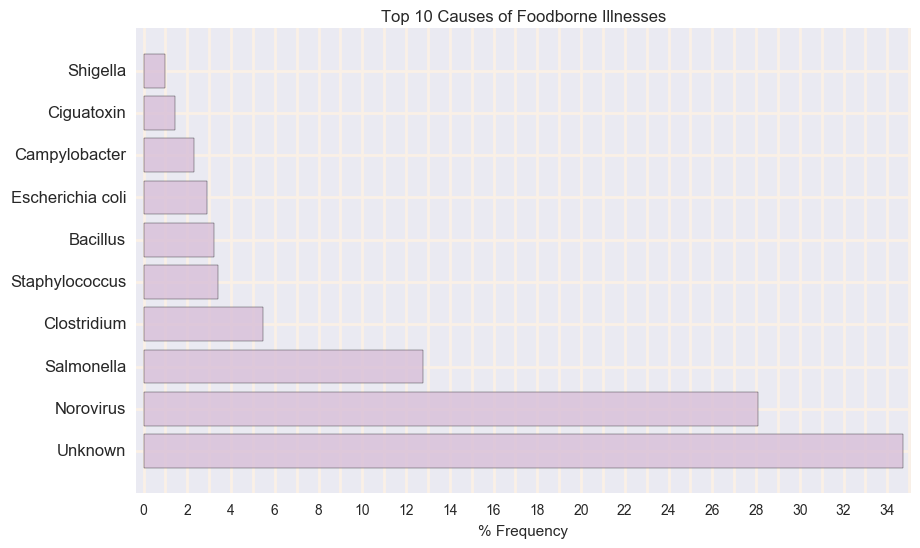

In [64]:
figure = plt.figure(figsize=(10, 6))

axes = figure.add_subplot(1, 1, 1)
axes.barh([i for i in xrange(len(toxins))], freq, color="thistle", align="center", alpha=0.8)
axes.set_xlabel( "% Frequency")
axes.set_xticks(np.arange(0, 0.36, 0.01))
axes.set_xticklabels(np.arange(0, 36, 1))
for label in axes.get_xticklabels()[1::2]:
    label.set_visible(False)
axes.set_yticks(np.arange(len(toxins)))
axes.set_yticklabels(toxins, rotation=0, fontsize=12, va="center", ha="right")
axes.set_title("Top 10 Causes of Foodborne Illnesses")
axes.margins(0.01, 0.01)
axes.yaxis.grid(True)
axes.set_ylim((-1, len(toxins)))
axes.grid(color='linen', linestyle='-', linewidth=2)
figure.savefig("species.pdf", transparent=True, frameon=True, bbox_inches="tight")

The most frequent pathogen is Norovirus, which, as described in its wikipedia entry, "is the most common cause of viral gastroenteritis in humans." 

To look at the ratio of hospitalizations and fatalities to illnesses, we will need to impute some missing values.

In [65]:
# http://stackoverflow.com/questions/35611465/python-scikit-learn-clustering-with-missing-data
from sklearn.cluster import KMeans

X = outbreaks[["Illnesses", "Hospitalizations", "Fatalities"]].as_matrix()
missing = ~np.isfinite(X)
mu = np.nanmean(X, 0, keepdims=1)
X_hat = np.where(missing, mu, X)
cls = KMeans(n_clusters=3)
labels = cls.fit_predict(X_hat)
centroids = cls.cluster_centers_
X_hat[missing] = centroids[labels][missing]

X_hat = pd.DataFrame(data=X_hat, index=outbreaks.index, columns=["Illnesses", "Hospitalizations", "Fatalities"])
X_hat.describe()

,Illnesses,Hospitalizations,Fatalities
count,19119.000000,19119.000000,19119.000000
mean,19.537162,0.951439,0.021716
std,49.452417,4.847073,0.348908
min,2.000000,0.000000,0.000000
25%,3.000000,0.000000,0.000000
50%,8.000000,0.000000,0.000000
75%,19.000000,0.724709,0.000000
max,1939.000000,308.000000,33.000000


In [66]:
outbreaks["Hospitalizations_imputed"] = X_hat["Hospitalizations"]
outbreaks["Fatalities_imputed"] = X_hat["Fatalities"]
outbreaks.describe()

,Illnesses,Hospitalizations,Fatalities,Hospitalizations_imputed,Fatalities_imputed
count,19119.000000,15494.000000,15518.000000,19119.000000,19119.000000
mean,19.537162,0.947528,0.021717,0.951439,0.021716
std,49.452417,5.312772,0.386976,4.847073,0.348908
min,2.000000,0.000000,0.000000,0.000000,0.000000
25%,3.000000,NaN,NaN,0.000000,0.000000
50%,8.000000,NaN,NaN,0.000000,0.000000
75%,19.000000,NaN,NaN,0.724709,0.000000
max,1939.000000,308.000000,33.000000,308.000000,33.000000


In [67]:
df = outbreaks[["Species", "Ingredient", "Illnesses", "Hospitalizations_imputed", "Fatalities_imputed"]]
df.fillna(value="Unknown", inplace=True)

sums = {}

source = pathogens.keys()

def search(myDict, lookup):
    for key, value in myDict.items():
        for v in value:
            if v in lookup:
                return key
    return None

def ingredient_count(dat, summed_df=sums):
    foods = {"Seafood": ["shellfish", "oysters", "shrimp", "clams", "crab", "crawfish/crayfish", 
                     "conch", "crustacean", "fish", "salmon", "tuna", "mussels", "scallops", 
                     "squid", "calamari"],
            "Dairy": ["cheese", "mozarella", "cream", "swiss", "parmesan", "butter", "milk", 
                     "frosting/icing", "queso fresco", "yogurt"],
            "Greens": ["lettuce", "collard greens", "kale", "leafy green", "spinach", "cabbage", 
                     "mesclun", "broccoli", "basil", "cilantro"],
            "Fruits": ["apple", "pineapple", "banana", "lemon", "lime", "mamey", "mango", "papaya", 
                      "peaches", "watermelon", "blackberries", "blueberries", "cantaloupe", "melon", 
                      "strawberries", "grapes", "avocado"],
            "Eggs": ["egg", "eggs", "mayonnaise"],
            "Sprouts": ["alfalfa", "clover"],
            "Meats": ["frog", "bear", "beef", "steak", "pork ", "boar", "goat", "lamb", "liver", 
                      "guinea", "venison"],
            "Poultry": ["chicken", "duck", "turkey"],        
             "Cured Meats": ["pepperroni", "ham", "salami", "bacon", "deli"],        
             "Grains": ["wraps/tortillas", "pasta", "rice", "cereal", "bread", "corn"],        
             "Drinks": ["juice", "coffee", "soft drinks", "drink mix"],        
             "Sauces": ["dressings", "gravy", "oil", "tahini"],        
             "Legumes": ["beans", "legume", "peas", "nuts", "tofu"],        
             "Nightshades": ["tomatoes", "eggplant", "potato", "peppers"],        
             "Gourds": ["cucumber", "squash", "zucchini", "pickles"],        
             "Carrot/Celery": ["carrots", "celery"],        
             "Other Vegetables": ["beets", "asparagus", "fern", "mushrooms", "fungus", "olives"]}
    foodcount = {}
    for fam in foods.keys():
        foodcount[fam] = 0
    for i in dat["Ingredient"]:
        if i == "Unknown":
            try:
                foodcount[i] += 1
            except:
                foodcount[i] = 1
        else:
            ingreds = [x.strip().lower() for x in i.split(";")]
            searching = True
            for f in ingreds:
                #print "search:", f
                while searching:
                    for key, value in foods.items():
                        for v in value:
                            #print "v:", v
                            if v in f:
                                #print "FOUND"
                                foodcount[key] += 1
                                break
                        
                        searching = False
                         
    #print foodcount            
    return foodcount
                        
for s in source:
    dat = df[df['Species'].str.contains(s)]
    if not dat.empty:
        ills = dat.sum()
        sums[s] = {"Illnesses": ills["Illnesses"], 
                   "Hospitalizations": np.round(ills["Hospitalizations_imputed"]/ills["Illnesses"]*100),
                  "Fatalities": np.round(ills["Fatalities_imputed"]/ills["Illnesses"]*100)}
        sums[s].update(ingredient_count(dat))

pat = re.compile(r"Chemical|Cleaning|metals|Pesticides")
dat2 = df[df['Species'].str.contains(pat)]
chem = dat2.sum(numeric_only=True)
sums["Chemical/Heavy Metals"] = {"Illnesses": chem["Illnesses"], 
                               "Hospitalizations": np.round(chem["Hospitalizations_imputed"]/chem["Illnesses"]*100),
                              "Fatalities": np.round(chem["Fatalities_imputed"]/chem["Illnesses"]*100)} 
sums["Chemical/Heavy Metals"].update(ingredient_count(dat2))

otherpat = re.compile(r"glutamate|herbal|tetrodotoxin|Histamine")
dat3 = df[df['Species'].str.contains(otherpat)]
others = dat3.sum(numeric_only=True)
sums["Other toxins"] = {"Illnesses": others["Illnesses"], 
                   "Hospitalizations": np.round(others["Hospitalizations_imputed"]/others["Illnesses"]*100),
                  "Fatalities": np.round(others["Fatalities_imputed"]/others["Illnesses"]*100)}  
sums["Other toxins"].update(ingredient_count(dat3))


sums = pd.DataFrame.from_dict(sums, orient="index")
sums.describe(include="all")

/Users/melissaluo/anaconda/lib/python2.7/site-packages/pandas/core/frame.py:2762: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


,Poultry,Grains,Unknown,Seafood,Carrot/Celery,Gourds,Dairy,Fruits,Other Vegetables,Hospitalizations,Illnesses,Greens,Eggs,Legumes,Fatalities,Meats,Cured Meats,Sprouts,Nightshades,Sauces,Drinks
count,35.000000,35.000000,34.000000,35.000000,35.000000,35.000000,35.000000,35.000000,35.000000,35.000000,35.000000,35.000000,35.000000,35.000000,35.000000,35.000000,35.000000,35.000000,35.000000,35.000000,35.000000
mean,9.057143,2.314286,518.029412,12.400000,0.142857,0.257143,4.400000,1.000000,0.457143,11.171429,10894.542857,3.714286,3.885714,1.028571,0.628571,6.885714,0.400000,0.142857,0.800000,0.771429,0.228571
std,23.330040,6.627800,1389.967113,33.746634,0.601119,0.852086,12.112706,2.128241,1.268228,15.917962,28414.752953,11.846001,19.428256,2.945442,2.613154,15.672703,1.142752,0.692092,1.875539,2.314732,0.910259
min,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,13.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,121.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,NaN,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,832.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,2.500000,0.000000,NaN,5.500000,0.000000,0.000000,2.500000,1.000000,0.000000,14.000000,5209.500000,1.000000,0.000000,0.000000,0.000000,3.000000,0.000000,0.000000,0.500000,0.000000,0.000000
max,119.000000,29.000000,6388.000000,177.000000,3.000000,4.000000,68.000000,9.000000,6.000000,71.000000,140101.000000,66.000000,115.000000,14.000000,15.000000,66.000000,6.000000,4.000000,9.000000,11.000000,5.000000


In [136]:
sums.max().sort_values(ascending=False)
sums.index

Index([u'Adenovirus', u'Anisakis', u'Astrovirus', u'Bacillus', u'Bacterium',
       u'Brucella', u'Campylobacter', u'Chemical/Heavy Metals', u'Ciguatoxin',
       u'Clostridium', u'Cryptosporidium', u'Cyclospora', u'Enterobacter',
       u'Enterococcus faecalis', u'Escherichia coli', u'Giardia',
       u'Hepatitis A', u'Listeria', u'Mycotoxins', u'Norovirus',
       u'Other toxins', u'Parasite', u'Rotavirus', u'Salmonella', u'Sapovirus',
       u'Scombroid toxin', u'Shigella', u'Staphylococcus', u'Streptococcus',
       u'Trichinella', u'Unknown', u'Vibrio', u'Virus', u'Yersinia',
       u'shellfish poison'],
      dtype='object')

We've normalized Hospitalizations and Fatalities so that is a percentage of Illnesses.

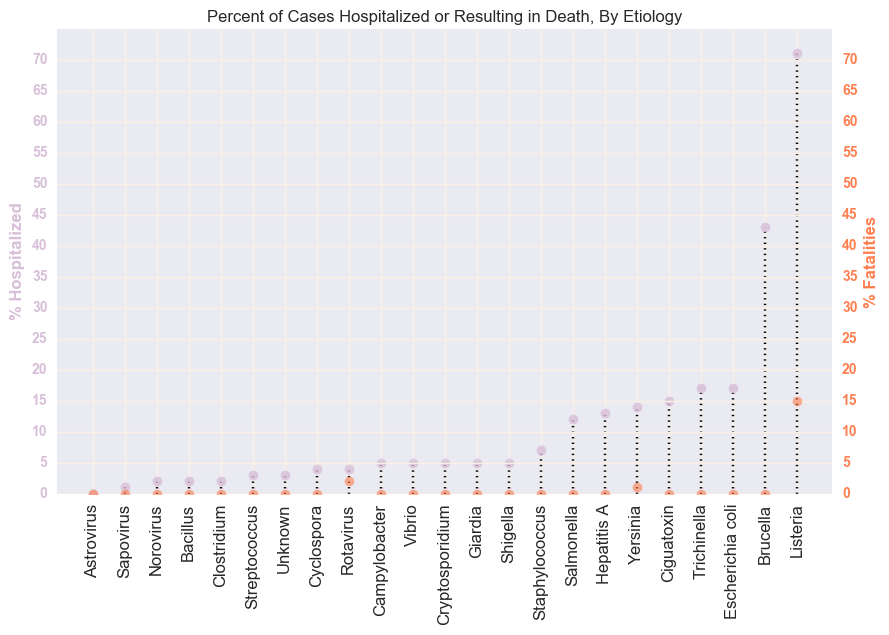

In [189]:
figure = plt.figure(figsize=(10, 6))

temp = sums.loc[["Cryptosporidium", "Cyclospora", "Giardia", "Trichinella", "Astrovirus", "Hepatitis A", 
                 "Norovirus", "Rotavirus", "Sapovirus", "Bacillus", "Clostridium", "Listeria", "Staphylococcus", 
                 "Streptococcus", "Brucella", "Campylobacter", "Escherichia coli", "Salmonella", "Shigella", 
                 "Vibrio", "Yersinia", "Unknown", "Ciguatoxin"], :].sort_values(["Hospitalizations"])

axes = figure.add_subplot(1, 1, 1)
n = [i for i in xrange(len(temp.index))]
axes.plot(n, temp["Hospitalizations"].tolist(), "o", color="thistle", alpha=0.8)
axes.vlines(n, [0], temp["Hospitalizations"].tolist(), linestyle="dotted")
axes.set_xticks(n)
axes.set_xticklabels(temp.index, rotation=90, fontsize=12)
axes.margins(0.05)
axes.set_ylim(0, 75)
axes.set_yticks(range(0, 75, 5))
axes.set_ylabel("% Hospitalized", color="thistle", fontsize=12, fontweight="bold")
axes.set_yticklabels(range(0, 75, 5), fontweight="bold")
for tl in axes.get_yticklabels():
    tl.set_color("thistle")

ax2 = axes.twinx()
ax2.plot(n, temp["Fatalities"].tolist(),"o", color="coral", alpha=0.6)
ax2.set_ylabel("% Fatalities", color="coral", fontsize=12, fontweight="bold")
ax2.margins(0.05)
ax2.set_ylim(0, 75)
ax2.set_yticks(range(0, 75, 5))
ax2.set_yticklabels(range(0, 75, 5), fontweight="bold")
for tl in ax2.get_yticklabels():
    tl.set_color("coral")
    
axes.set_title("Percent of Cases Hospitalized or Resulting in Death, By Etiology")

axes.grid(color='linen', linestyle='-', linewidth=1)
ax2.grid(color='linen', linestyle='-', linewidth=1)
figure.savefig("deadliness.pdf", transparent=True, frameon=True, bbox_inches="tight")

Though Norovirus is the most common pathogen of foodborne illnesses, it is not particularly deadly. Listeria, a bacterial genus, seems to be the deadliest with over 70% of patients hospitalizaed and nearly 15% resulting in death. The other two deadly pathogens/toxins are Mycotoxins (toxic compounds produced by fungi) and Rotavirus, a RNA virus that is, according to its wikipedia entry, "the most common cause of diarrhoeal disease among infants and young children." Perhaps its fatality rate is due to its patients being young with underdeveloped immune systems. 

In [71]:
food_cols = ['Poultry', 'Cured Meats', 'Grains', 'Seafood', 'Gourds', 'Dairy', 'Fruits', 'Greens', 'Eggs', 'Legumes', 'Meats', 'Carrot Family', 'Others', 'Sprouts', 'Nightshades', 'Sauces','Drinks']
parasites = ["Cryptosporidium", "Cyclospora", "Giardia", "Trichinella"]
viruses = ["Astrovirus", "Hepatitis A", "Norovirus", "Rotavirus", "Sapovirus"]
gram_pos = ["Bacillus", "Clostridium", "Listeria", "Staphylococcus", "Streptococcus"]
gram_neg = ["Brucella", "Campylobacter", "Escherichia coli", "Salmonella", "Shigella", "Vibrio", "Yersinia"]

parasites_temp = sums.loc[parasites, food_cols]
viruses_temp = sums.loc[viruses, food_cols]
pos_temp = sums.loc[gram_pos, food_cols]
neg_temp = sums.loc[gram_neg, food_cols]

print parasites_temp.max(axis=0).tolist()
print [max(cr, cy, g, t) for cr, cy, g, t in zip(parasites_temp.loc["Cryptosporidium"].tolist(), 
                                                parasites_temp.loc["Cyclospora"].tolist(), 
                                                parasites_temp.loc["Giardia"].tolist(), 
                                                parasites_temp.loc["Trichinella"].tolist())]

[0.0, 0.0, 0.0, 0.0, 0.0, 4.0, 2.0, 1.0, 0.0, 0.0, 3.0, nan, nan, 0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0, 0.0, 4.0, 2.0, 1.0, 0.0, 0.0, 3.0, nan, nan, 0.0, 0.0, 0.0, 0.0]


In [77]:
food_cols = ['Dairy', 'Eggs', 'Poultry', 'Meats', 'Seafood', 'Grains', 'Fruits', 'Greens', 
             'Nightshades']
other_causes = ["Norovirus", "Unknown", "Ciguatoxin"]
gram_pos = ["Bacillus", "Clostridium", "Staphylococcus"]
gram_neg = ["Escherichia coli", "Salmonella", "Shigella", "Campylobacter"]

other_temp = sums.loc[other_causes, food_cols]
pos_temp = sums.loc[gram_pos, food_cols]
neg_temp = sums.loc[gram_neg, food_cols]

markers = ["o", "s", "^",  "D"]
colors = ["coral", "thistle", "teal", "peru"]

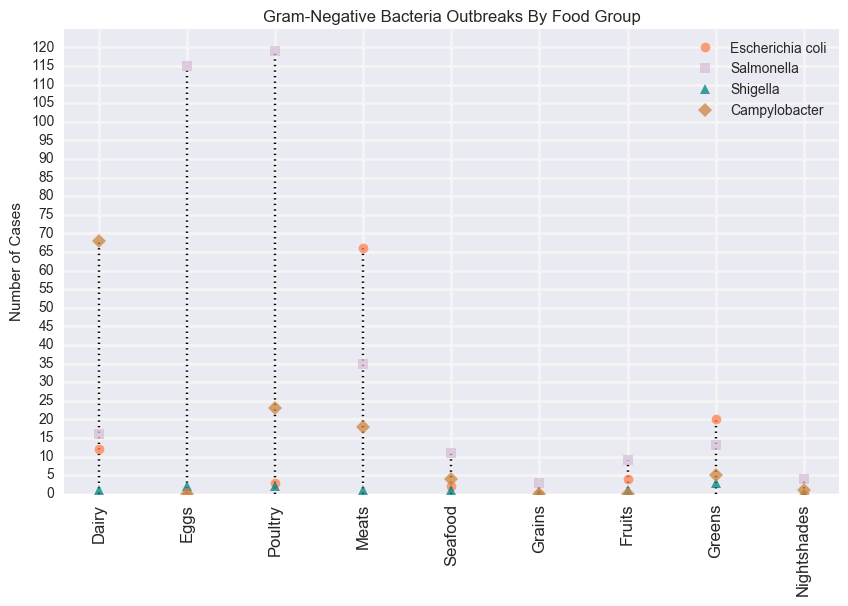

In [79]:
figure = plt.figure(figsize=(10, 6))
axes.grid(color='whitesmoke', linestyle='-', linewidth=2)

axes = figure.add_subplot(1, 1, 1)
n = [i for i in xrange(len(neg_temp.columns))]
for i, (ind, row) in enumerate(neg_temp.iterrows()):
    axes.plot(n, row.tolist(), markers[i], color=colors[i], alpha=0.75, label=ind)
axes.vlines(n, [0], neg_temp.max(axis=0).tolist(), linestyle="dotted")
axes.set_xticks(n)
axes.set_xticklabels(neg_temp.columns, rotation=90, fontsize=12)
axes.margins(0.05)
axes.set_ylim(0, 125)
axes.set_ylabel("Number of Cases")
axes.set_yticks(range(0, 125, 5))
axes.legend()  
axes.set_title("Gram-Negative Bacteria Outbreaks By Food Group")
axes.grid(color='whitesmoke', linestyle='-', linewidth=2)

figure.savefig("gramneg.pdf", transparent=True, frameon=True, bbox_inches="tight")

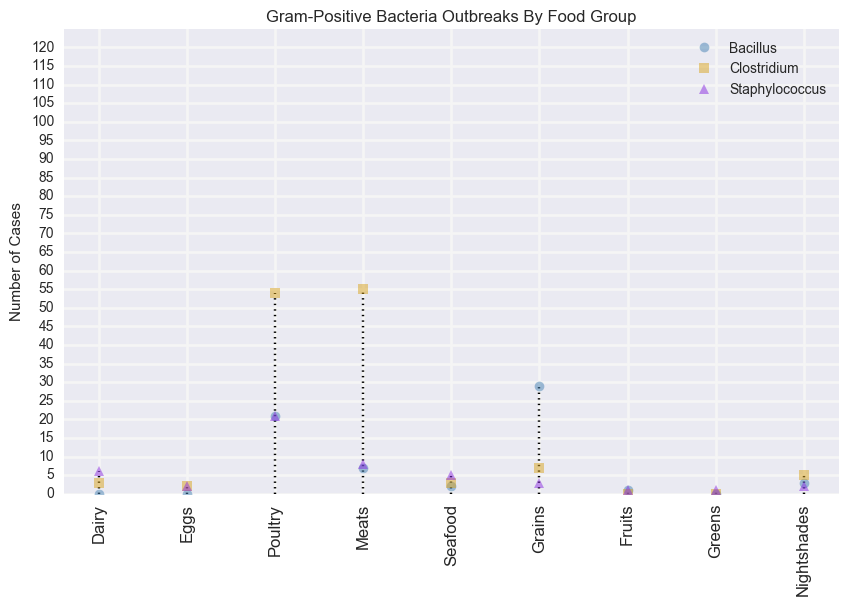

In [150]:
figure = plt.figure(figsize=(10, 6))
axes.grid(color='whitesmoke', linestyle='-', linewidth=2)

axes = figure.add_subplot(1, 1, 1)
n = [i for i in xrange(len(pos_temp.columns))]
for i, (ind, row) in enumerate(pos_temp.iterrows()):
    axes.plot(n, row.tolist(), markers[i], color=colors[i], alpha=0.5, label=ind)
axes.vlines(n, [0], pos_temp.max(axis=0).tolist(), linestyle="dotted")
axes.set_xticks(n)
axes.set_xticklabels(pos_temp.columns, rotation=90, fontsize=12)
axes.margins(0.05)
axes.set_ylim(0, 125)
axes.set_ylabel("Number of Cases")
axes.set_yticks(range(0, 125, 5))
axes.legend()  
axes.set_title("Gram-Positive Bacteria Outbreaks By Food Group")
axes.grid(color='whitesmoke', linestyle='-', linewidth=2)

figure.savefig("grampos.pdf", transparent=True, frameon=True, bbox_inches="tight")

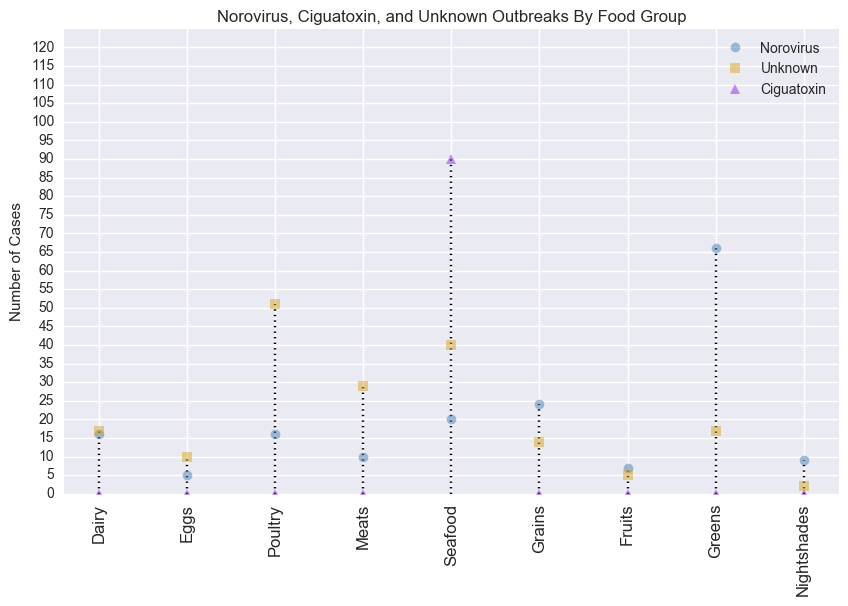

In [151]:
figure = plt.figure(figsize=(10, 6))
axes.grid(color='whitesmoke', linestyle='-', linewidth=2)

axes = figure.add_subplot(1, 1, 1)

n = [i for i in xrange(len(other_temp.columns))]
for i, (ind, row) in enumerate(other_temp.iterrows()):
    axes.plot(n, row.tolist(), markers[i], color=colors[i], alpha=0.5, label=ind)
axes.vlines(n, [0], other_temp.max(axis=0).tolist(), linestyle="dotted")
axes.set_xticks(n)
axes.set_xticklabels(other_temp.columns, rotation=90, fontsize=12)
axes.margins(0.05)
axes.set_ylim(0, 125)
axes.set_ylabel("Number of Cases")
axes.set_yticks(range(0, 125, 5))
axes.legend()  
axes.set_title("Norovirus, Ciguatoxin, and Unknown Outbreaks By Food Group")
figure.savefig("others.pdf", transparent=True, frameon=True, bbox_inches="tight")

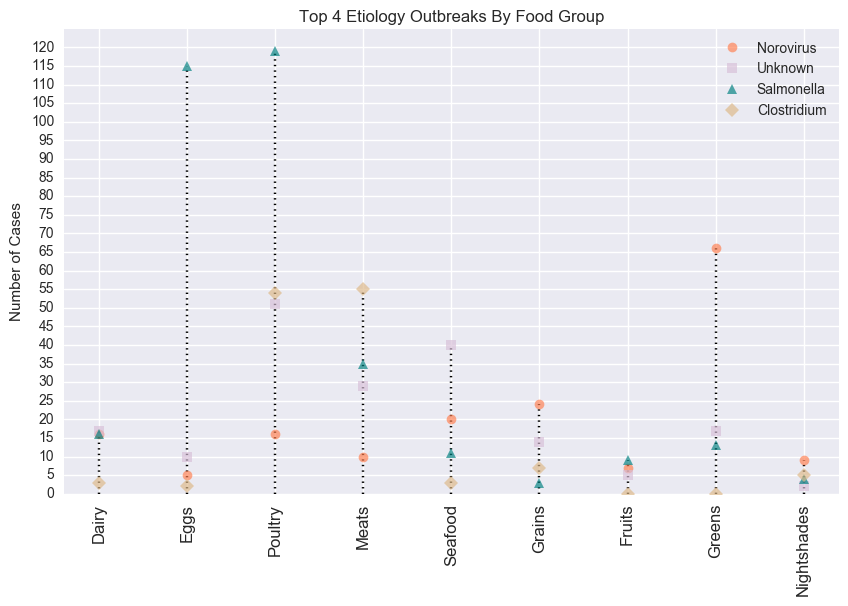

In [82]:
food_cols = ['Dairy', 'Eggs', 'Poultry', 'Meats', 'Seafood', 'Grains', 'Fruits', 'Greens', 
             'Nightshades']
top = ["Norovirus", "Unknown", "Salmonella", "Clostridium"]
top_temp = sums.loc[top, food_cols]

markers = ["o", "s", "^",  "D"]
colors = ["coral", "thistle", "teal", "burlywood"]

figure = plt.figure(figsize=(10, 6))
axes.grid(color='whitesmoke', linestyle='-', linewidth=2)

axes = figure.add_subplot(1, 1, 1)

n = [i for i in xrange(len(top_temp.columns))]
for i, (ind, row) in enumerate(top_temp.iterrows()):
    axes.plot(n, row.tolist(), markers[i], color=colors[i], alpha=0.67, label=ind)
axes.vlines(n, [0], top_temp.max(axis=0).tolist(), linestyle="dotted")
axes.set_xticks(n)
axes.set_xticklabels(top_temp.columns, rotation=90, fontsize=12)
axes.margins(0.05)
axes.set_ylim(0, 125)
axes.set_ylabel("Number of Cases")
axes.set_yticks(range(0, 125, 5))
axes.legend()  
axes.set_title("Top 4 Etiology Outbreaks By Food Group")
figure.savefig("top.pdf", transparent=True, frameon=True, bbox_inches="tight")